In [25]:
import os
os.environ['LD_LIBRARY_PATH'] = '/workspaces/artificial_intelligence/.venv/lib/python3.11/site-packages/tensorrt_libs'

import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

import tensorflow as tf
import keras
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

In [35]:
import os, shutil
# Unzip file
!mkdir -p dogscats/subset
!unzip -o -q dogs-vs-cats-subset.zip -d dogscats

base_dir = 'dogscats/subset'
train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(base_dir, 'train', 'cats')
train_dogs_dir = os.path.join(base_dir, 'train', 'dogs')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')



In [36]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
from tensorflow.keras import optimizers

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['acc']
)


In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break


history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator  # Try without validation_steps
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - acc: 0.6152 - loss: 0.6548 - val_acc: 0.6360 - val_loss: 0.6428
Epoch 2/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6360 - val_loss: 0.6428
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - acc: 0.6689 - loss: 0.6184 - val_acc: 0.6130 - val_loss: 0.6688
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6130 - val_loss: 0.6688
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - acc: 0.7049 - loss: 0.5703 - val_acc: 0.6450 - val_loss: 0.6398
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6450 - val_loss: 0.6398
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - acc: 0.7199 - loss: 0.5619 - val_acc: 0.6900 - val_loss: 0.5849
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.6900 - val_loss: 0.5849
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - acc: 0.7411 - loss: 0.5197 - val_acc: 0.6820 - val_loss: 0.5819
Epoch 10/30
100/100

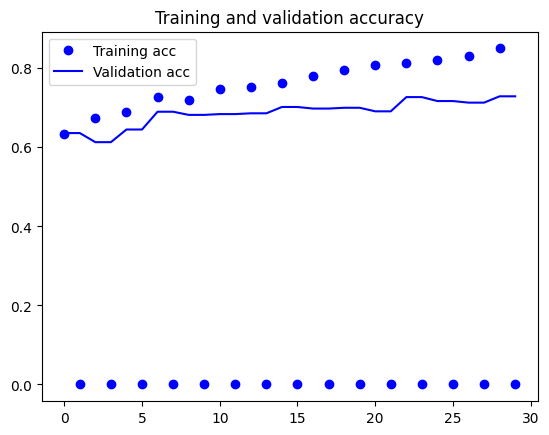

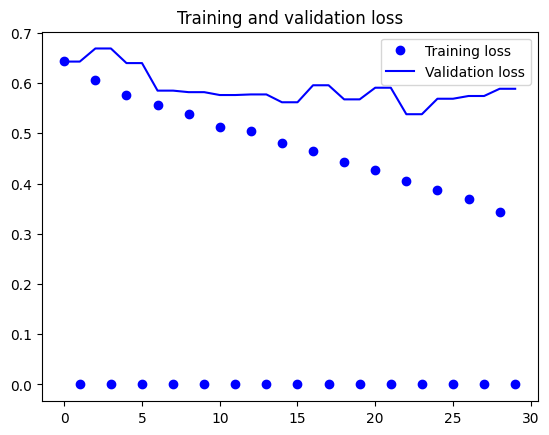

In [50]:
import matplotlib.pyplot as plt
model.save('cats_and_dogs_small_1.h5')

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

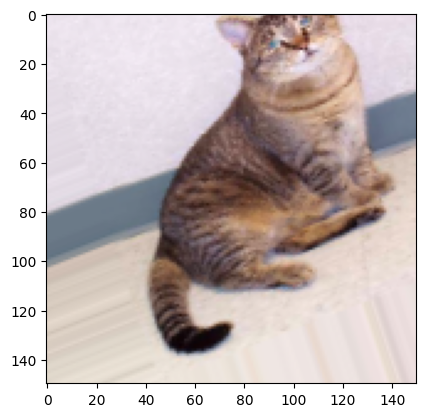

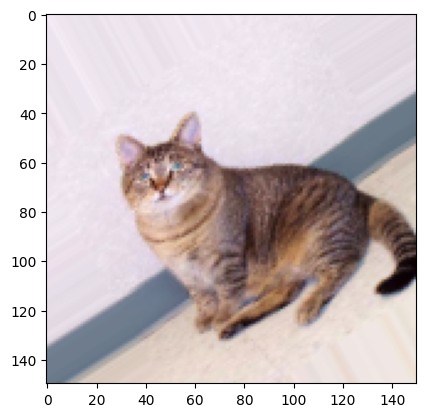

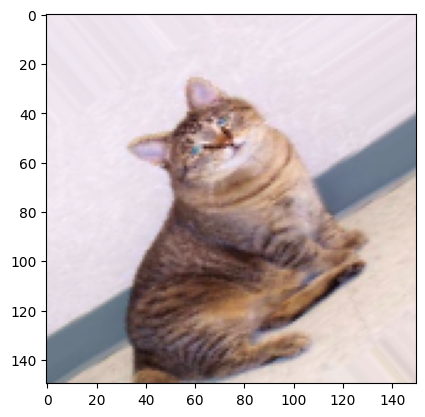

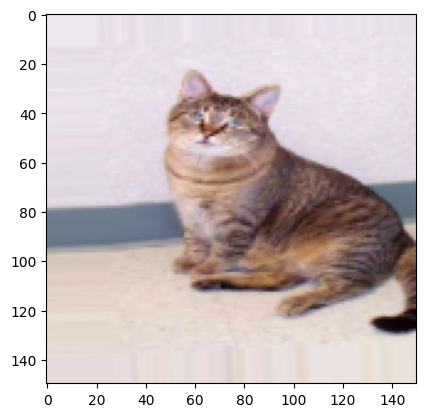

In [46]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
# This is module with image preprocessing utilities
import keras.utils as image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [49]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['acc']
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['acc']
)

In [53]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [55]:
history = model.fit(
      train_generator,
      steps_per_epoch=2000//train_generator.batch_size,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=500//validation_generator.batch_size)

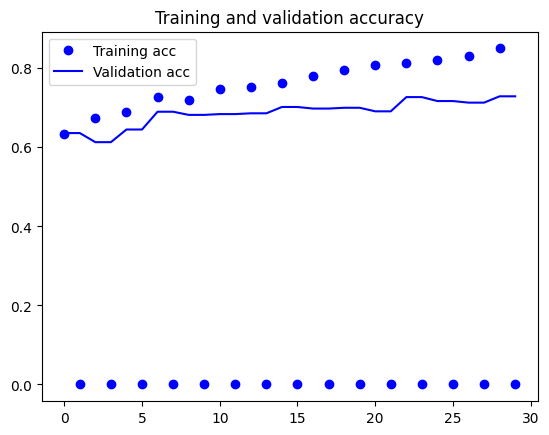

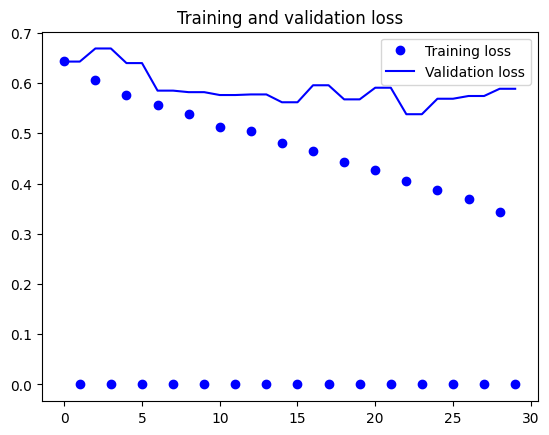

In [56]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [60]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total Detections ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

  # Get the number of samples in the training dataset
num_samples = len(train_generator)

# Initialize empty arrays to store training data and labels
all_data = []
all_labels = []

# Iterate through the generator to collect data and labels
for i in range(num_samples):
    data_batch, labels_batch = train_generator[i]
    all_data.append(data_batch)
    all_labels.append(labels_batch)

# Concatenate the data and labels arrays to obtain the full training dataset
train_data = np.concatenate(all_data)
train_labels = np.concatenate(all_labels)

train_predictions_baseline = model.predict(train_data, batch_size=32)



# Get the number of samples in the training dataset
num_samples = len(validation_generator)

# Initialize empty arrays to store training data and labels
all_data = []
all_labels = []

# Iterate through the generator to collect data and labels
for i in range(num_samples):
    data_batch, labels_batch = validation_generator[i]
    all_data.append(data_batch)
    all_labels.append(labels_batch)

# Concatenate the data and labels arrays to obtain the full training dataset
test_data = np.concatenate(all_data)
test_labels = np.concatenate(all_labels)

# train_features = model.predict_generator(train_generator, verbose=1)
# test_features = model.predict_generator(train_generator, verbose=1)
# train_labels = train_generator.classes
# test_labels = validation_generator.classes

test_predictions_baseline = model.predict(test_data, batch_size=32)

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 573ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 579ms/step


loss :  0.5035536289215088
compile_metrics :  0.7429999709129333

True Negatives:  400
False Positives:  100
False Negatives:  157
True Positives:  343
Total Detections  500


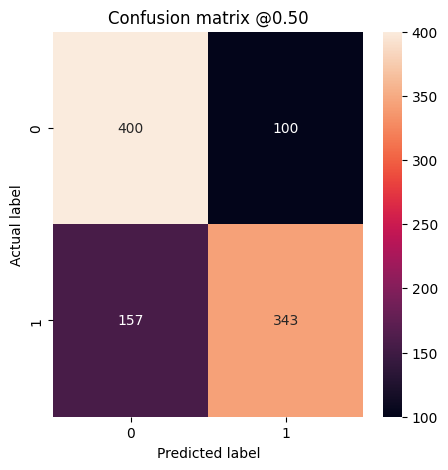

In [61]:

baseline_results = model.evaluate(test_data, test_labels,
                                  batch_size=32, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [ ]:
!pip install captum

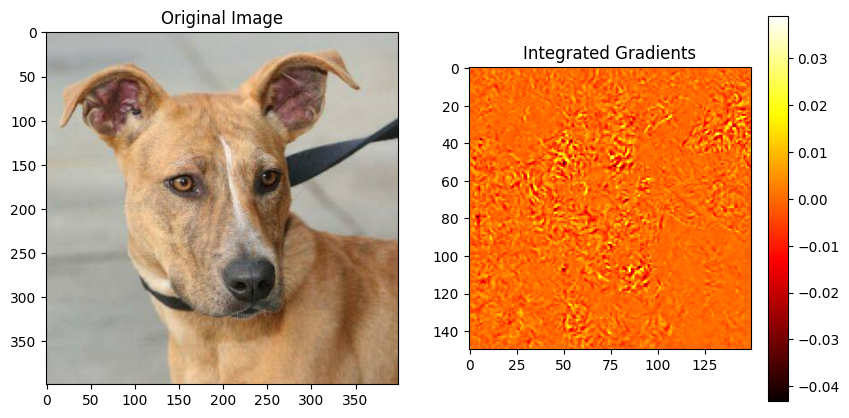

In [69]:

import os
import random
import torch
import torch.nn as nn
from torchvision import models, transforms
from captum.attr import IntegratedGradients, LayerGradCam
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

model = models.resnet18(weights='DEFAULT')
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.eval()

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

cat_dog_folders = os.listdir(train_dir)
random_folder = random.choice(cat_dog_folders)

image_files = os.listdir(os.path.join(train_dir, random_folder))
random_image_file = random.choice(image_files)
img_path = os.path.join(train_dir, random_folder, random_image_file)

img = Image.open(img_path)
input_img = transform(img).unsqueeze(0)

# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Set a baseline(black) and compute attributions
baseline = torch.zeros_like(input_img)
attributions, delta = ig.attribute(input_img, baseline, target=0, return_convergence_delta=True)

# Visualize the attributions
attributions = attributions.squeeze().detach().numpy().transpose(1, 2, 0)  # Remove batch dim and adjust format
attributions = np.mean(attributions, axis=-1)  # Average across color channels for visualization

# Display the original image and its attributions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(attributions, cmap="hot")
plt.title("Integrated Gradients")
plt.colorbar()
plt.show()



# **Integrated Gradients**
- Image is resized and converted to a tensor
- Define the baseline and then calculate the gradients from the baseline to the actual image
- Average across color channels to highlight the areas that contribute the most to the models prediction

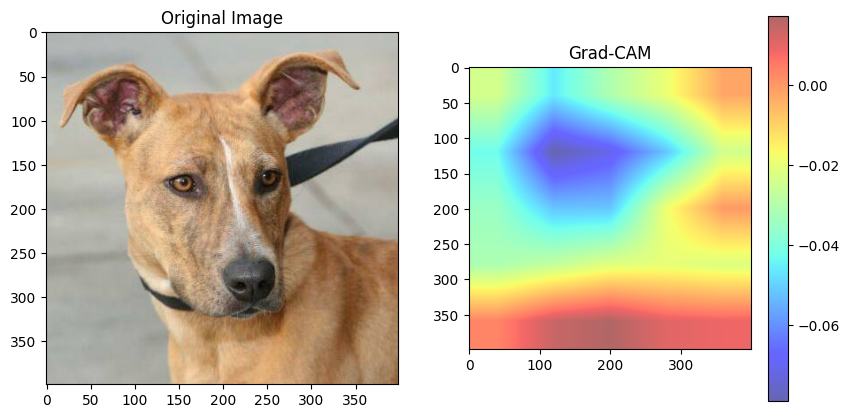

In [70]:
layer_gc = LayerGradCam(model, model.layer4[-1])

grads = layer_gc.attribute(input_img, target=0)

# Upscale to original image dimensions for better visualization
upsampled_grads = cv2.resize(grads.squeeze().detach().numpy(), (img.width, img.height))

# Visualize Grad-CAM output
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(upsampled_grads, cmap="jet", alpha=0.6)
plt.title("Grad-CAM")
plt.colorbar()
plt.show()


# **Grad-CAM**
- Backpropagating gradients to to the last convolution layer
- LayerGradCam is used to calculate the weighted gradients
- Resize and visualize the Grad-CAM output, blending it with the original image to make the visualization clear
